# Sklearn Native Imputation Methods

For various reasons, many real world datasets contain missing values, often encoded as blanks, NaNs or other placeholders. Such datasets however are incompatible with scikit-learn estimators which assume that all values in an array are numerical, and that all have and hold meaning. A basic strategy to use incomplete datasets is to discard entire rows and/or columns containing missing values. However, this comes at the price of losing data which may be valuable (even though incomplete). A better strategy is to impute the missing values, i.e., to infer them from the known part of the data. See the glossary entry on imputation.

## Univariate vs. Multivariate Imputation

One type of imputation algorithm is univariate, which imputes values in the i-th feature dimension using only non-missing values in that feature dimension (e.g. `SimpleImputer`). By contrast, multivariate imputation algorithms use the entire set of available feature dimensions to estimate the missing values (e.g. `IterativeImputer`).

## Univariate feature imputation

The `SimpleImputer` class provides basic strategies for imputing missing values. Missing values can be imputed with a provided constant value, or using the statistics (mean, median or most frequent) of each column in which the missing values are located. This class also allows for different missing values encodings.

The following snippet demonstrates how to replace missing values, encoded as np.nan, using the mean value of the columns (axis 0) that contain the missing values:

In [40]:
import numpy as np
from sklearn.impute import SimpleImputer
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp.fit([[1, 2], [np.nan, 3], [7, 6]])
X = [[np.nan, 2], [6, np.nan], [7, 6]]
print(imp.transform(X))

[[4.         2.        ]
 [6.         3.66666667]
 [7.         6.        ]]


The `SimpleImputer` class also supports sparse matrices:

In [41]:
import scipy.sparse as sp
X = sp.csc_matrix([[1, 2], [0, -1], [8, 4]])
imp = SimpleImputer(missing_values=-1, strategy='mean')
imp.fit(X)
X_test = sp.csc_matrix([[-1, 2], [6, -1], [7, 6]])
print(imp.transform(X_test).toarray())

[[3. 2.]
 [6. 3.]
 [7. 6.]]


Note that this format is not meant to be used to implicitly store missing values in the matrix because it would densify it at transform time. Missing values encoded by 0 must be used with dense input.

The `SimpleImputer` class also supports categorical data represented as string values or pandas categoricals when using the 'most_frequent' or 'constant' strategy:

In [42]:
import pandas as pd
df = pd.DataFrame([["a", "x"],
                   [np.nan, "y"],
                   ["a", np.nan],
                   ["b", "y"]], dtype="category")
imp = SimpleImputer(strategy="most_frequent")
print(imp.fit_transform(df))

[['a' 'x']
 ['a' 'y']
 ['a' 'y']
 ['b' 'y']]


## Sklearn Multivariate Feature Imputation

A more sophisticated approach is to use the `IterativeImputer` class, which models each feature with missing values as a function of other features, and uses that estimate for imputation. It does so in an iterated round-robin fashion: at each step, a feature column is designated as output `y` and the other feature columns are treated as inputs `X`. A regressor is fit on `(X, y)` for known `y`. Then, the regressor is used to predict the missing values of `y`. This is done for each feature in an iterative fashion, and then is repeated for `max_iter` imputation rounds. The results of the final imputation round are returned.

**Note**

This estimator is still experimental for now: default parameters or details of behaviour might change without any deprecation cycle. Resolving the following issues would help stabilize `IterativeImputer`: convergence criteria (#14338) and default estimators (#13286). To use it, you need to explicitly import `enable_iterative_imputer`.

In [43]:
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
imp = IterativeImputer(max_iter=10, random_state=0)
imp.fit([[1, 2], [3, 6], [4, 8], [np.nan, 3], [7, np.nan]])
X_test = [[np.nan, 2], [6, np.nan], [np.nan, 6]]
# the model learns that the second feature is double the first
print(np.round(imp.transform(X_test)))

[[ 1.  2.]
 [ 6. 12.]
 [ 3.  6.]]


Both `SimpleImputer` and `IterativeImputer` can be used in a Pipeline as a way to build a composite estiamtor that supports imputation. We'll explore that here.

[Resource](https://scikit-learn.org/stable/auto_examples/impute/plot_missing_values.html#sphx-glr-auto-examples-impute-plot-missing-values-py)

## Example: Imputing Missing Values Before Building an Estimator

This example covers
* Imputation by the constant value 0
* Imputation by the mean value of each feature
* k nearest neighbor imputation
* Iterative imputation

In all cases, for each feature, we add a new feature indicating the missingness. Let's load in the data and input some fake missing values.

In [44]:
import numpy as np

from sklearn.datasets import fetch_california_housing, load_diabetes

X_diabetes, y_diabetes = load_diabetes(return_X_y=True)
X_california, y_california = fetch_california_housing(return_X_y=True)

X_diabetes = X_diabetes[:300]
y_diabetes = y_diabetes[:300]
X_california = X_california[:300]
y_california = y_california[:300]


def add_missing_values(X_full, y_full, rng):
    n_samples, n_features = X_full.shape

    # Add missing values in 75% of the lines
    missing_rate = 0.75
    n_missing_samples = int(n_samples * missing_rate)

    missing_samples = np.zeros(n_samples, dtype=bool)
    missing_samples[:n_missing_samples] = True

    rng.shuffle(missing_samples)
    missing_features = rng.randint(0, n_features, n_missing_samples)
    X_missing = X_full.copy()
    X_missing[missing_samples, missing_features] = np.nan
    y_missing = y_full.copy()

    return X_missing, y_missing


rng = np.random.RandomState(42)
X_miss_diabetes, y_miss_diabetes = add_missing_values(X_diabetes, y_diabetes, rng)
X_miss_california, y_miss_california = add_missing_values(
    X_california, y_california, rng
)

### Impute the Missing Data and Score

Now we'll write a function which will score the results on the differently imputed data (mmmm sounds useful for our other comparison purposes as well), including the case of no imputation for full data. We will use `RandomForestRegressor` for the target regression.

In [45]:
from sklearn.ensemble import RandomForestRegressor

# To use the experimental IterativeImputer, we need to explicitly ask for it:
from sklearn.experimental import enable_iterative_imputer  # noqa: F401
from sklearn.impute import IterativeImputer, KNNImputer, SimpleImputer
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler

N_SPLITS = 4


def get_score(X, y, imputer=None):
    regressor = RandomForestRegressor(random_state=0)
    if imputer is not None:
        estimator = make_pipeline(imputer, regressor)
    else:
        estimator = regressor
    scores = cross_val_score(
        estimator, X, y, scoring="neg_mean_squared_error", cv=N_SPLITS
    )
    return scores.mean(), scores.std()


x_labels = []

mses_diabetes = np.zeros(5)
stds_diabetes = np.zeros(5)
mses_california = np.zeros(5)
stds_california = np.zeros(5)

### Estimate the Score

First, we want to estimate the score on the original data:

In [46]:
mses_diabetes[0], stds_diabetes[0] = get_score(X_diabetes, y_diabetes)
mses_california[0], stds_california[0] = get_score(X_california, y_california)
x_labels.append("Full Data")

### Replace Missing Values by 0

Now we will estimate the score on the data where the missing values are replaced by 0:

In [47]:
imputer = SimpleImputer(strategy="constant", fill_value=0, add_indicator=True)
mses_diabetes[1], stds_diabetes[1] = get_score(
    X_miss_diabetes, y_miss_diabetes, imputer
)
mses_california[1], stds_california[1] = get_score(
    X_miss_california, y_miss_california, imputer
)
x_labels.append("Zero Imputation")

### Impute Missing Values with Mean

In [48]:
imputer = SimpleImputer(strategy="mean", add_indicator=True)
mses_diabetes[2], stds_diabetes[2] = get_score(
    X_miss_diabetes, y_miss_diabetes, imputer
)
mses_california[2], stds_california[2] = get_score(
    X_miss_california, y_miss_california, imputer
)
x_labels.append("Mean Imputation")

kNN-Imputation of the Missing Values

`KNNImputer` imputes missing values using the weighted or unweighted mean of the desired number of nearest neighbors. If your features have vastly different scales (as in the California dataset), consider re-scaling them to potentially improve performance.

In [49]:
imputer = KNNImputer(add_indicator=True)
mses_diabetes[3], stds_diabetes[3] = get_score(
    X_miss_diabetes, y_miss_diabetes, imputer
)
mses_california[3], stds_california[3] = get_score(
    X_miss_california, y_miss_california, make_pipeline(RobustScaler(), imputer)
)
x_labels.append("KNN Imputation")

### Iterative Imputation of the Missing Values

Another option is the `IterativeImputer`. This uses round-robin regression, modeling each feature with missing values as a function of other features, in turn. We use the class's default choice of the regressor model (`BaysianRidge`) to predict missing feature values. The performance of the predictor may be negatively affected by vastly different scales of the features, so we re-scale the features in the California housing dataset.

In [50]:
imputer = IterativeImputer(add_indicator=True)

mses_diabetes[4], stds_diabetes[4] = get_score(
    X_miss_diabetes, y_miss_diabetes, imputer
)
mses_california[4], stds_california[4] = get_score(
    X_miss_california, y_miss_california, make_pipeline(RobustScaler(), imputer)
)
x_labels.append("Iterative Imputation")

mses_diabetes = mses_diabetes * -1
mses_california = mses_california * -1

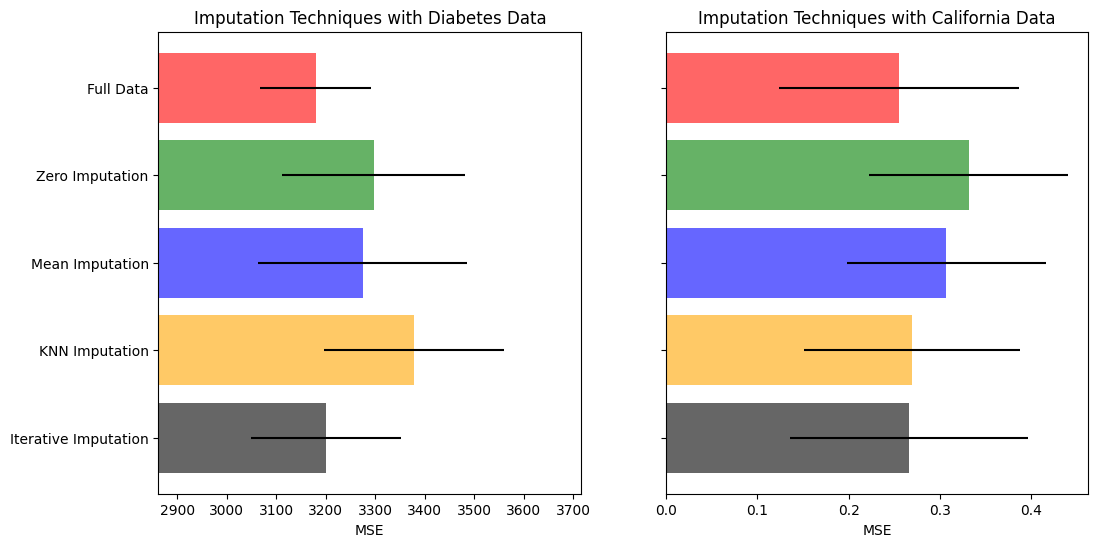

In [51]:
import matplotlib.pyplot as plt

n_bars = len(mses_diabetes)
xval = np.arange(n_bars)

colors = ["r", "g", "b", "orange", "black"]

# plot diabetes results
plt.figure(figsize=(12, 6))
ax1 = plt.subplot(121)
for j in xval:
    ax1.barh(
        j,
        mses_diabetes[j],
        xerr=stds_diabetes[j],
        color=colors[j],
        alpha=0.6,
        align="center",
    )

ax1.set_title("Imputation Techniques with Diabetes Data")
ax1.set_xlim(left=np.min(mses_diabetes) * 0.9, right=np.max(mses_diabetes) * 1.1)
ax1.set_yticks(xval)
ax1.set_xlabel("MSE")
ax1.invert_yaxis()
ax1.set_yticklabels(x_labels)

# plot california dataset results
ax2 = plt.subplot(122)
for j in xval:
    ax2.barh(
        j,
        mses_california[j],
        xerr=stds_california[j],
        color=colors[j],
        alpha=0.6,
        align="center",
    )

ax2.set_title("Imputation Techniques with California Data")
ax2.set_yticks(xval)
ax2.set_xlabel("MSE")
ax2.invert_yaxis()
ax2.set_yticklabels([""] * n_bars)

plt.show()

You can also try different techniques. For example, the median is a more robust estimator for data with high magnitude variables which could dominate results (long tail).

# Multivariate Imputation

Even though we already did an example for it, let's look at the `IterativeImputer` class, which models each feature with missing values as a function of other features, and uses that estimate for imputation. It does so in an iterated round-robin fashion: at each step, a feature column is designated as output `y` and the other feature columns are treated as inputs `X`. A regressor is fit on `(X, y)` for known `y`. Then, the regressor is used to predict the missing values of `y`. This is done for each feature in an iterative fashion, and then is repeated for `max_iter` imputation rounds. The results of the final imputation round are returned.

**Note**

This estimator is still (surprise) experimental for now. Default parameters or details of behavior might change without any deprecation cycle. No matter, we will probably use other means for missing value imputation after this repository is complete.

In [52]:
imp = IterativeImputer(max_iter=10, random_state=0)
imp.fit([[1, 2], [3, 6], [4, 8], [np.nan, 3], [7, np.nan]])

,estimator,None
,missing_values,nan
,sample_posterior,False
,max_iter,10
,tol,0.001
,n_nearest_features,None
,initial_strategy,'mean'
,fill_value,None
,imputation_order,'ascending'
,skip_complete,False
,min_value,-inf


In [53]:
X_test = [[np.nan, 2], [6, np.nan], [np.nan, 6]]
print(np.round(imp.transform(X_test)))

[[ 1.  2.]
 [ 6. 12.]
 [ 3.  6.]]


Both `SimpleImputer` and `IterativeImputer` can be used in a Pipeline as a way to build a composite estimator that supports imputation. This was explored in the example earlier.

Now we're gonna dive into another example that expands upon `IterativeImputer`. 

# Example: Flexibility of IterativeImputer - Imputing Missing Values with Variants of IterativeImputer

The `IterativeImputer` class is very flexible - it can be used with a variety of estimators to do round-robin regression, treating every variable as an output in turn.

In this example, we compare some estimators for the purpose of missing feature imputation with `IterativeImputer`:
* `BayesianRidge`: Regularized linear regression
* `RandomForestRegressor`: Forests of randomized trees regression
* `make_pipeline` (`Nystroem`, `Ridge`): a pipeline with the the expansion of a degree 2 polynomial kernel and regularized linear regression
* `KNeightborsRegressor`: Comparable to other KNN approaches

Of particular interest is the ability of `IterativeImputer` to mimic the behavior of missForest, a popular imputation package for R.

Note that `KNeighborsRegressor` is different from KNN imputation, which learns from samples with missing values using a distance metric that accounts for missing values, rather than imputing them.

The goal is to compare different estimators to see which one is best for the `IterativeImputer` when using a `BayesianRidge` estimator on the California housing dataset with a single value randomly removed from each row.

For this particular pattern of missing values we see that `BayesianRidge` and `RandomForestRegressor` give the best results.

It should be noted that some estimators such as `HistGradientBoostingRegressor` can natively deal with missing features and are often recommended over building pipelines with complex and costly missing values imputation strategies.

![Alt image](../images/sphx_glr_plot_iterative_imputer_variants_comparison_001.png)

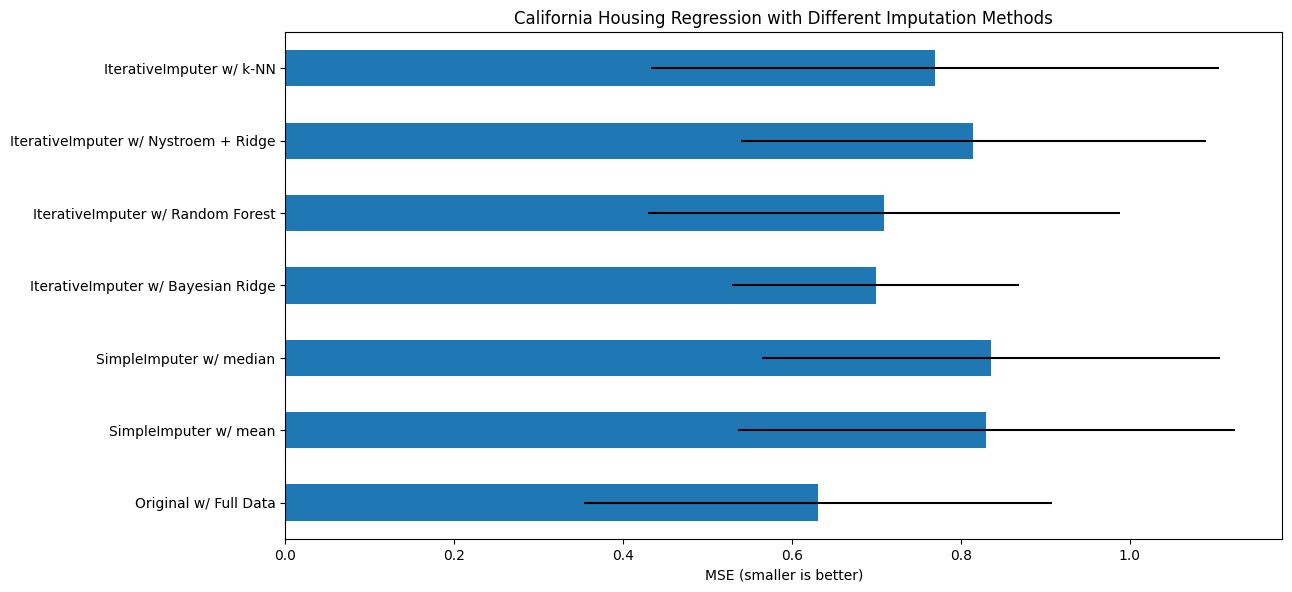

In [58]:
# Authors: The scikit-learn developers
# SPDX-License-Identifier: BSD-3-Clause

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.datasets import fetch_california_housing
from sklearn.ensemble import RandomForestRegressor

# To use this experimental feature, we need to explicitly ask for it:
from sklearn.experimental import enable_iterative_imputer  # noqa: F401
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.kernel_approximation import Nystroem
from sklearn.linear_model import BayesianRidge, Ridge
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler

N_SPLITS = 5

X_full, y_full = fetch_california_housing(return_X_y=True)
# ~2k samples is enough for the purpose of the example.
# Remove the following two lines for a slower run with different error bars.
X_full = X_full[::10]
y_full = y_full[::10]
n_samples, n_features = X_full.shape


def compute_score_for(X, y, imputer=None):
    # We scale data before imputation and training a target estimator,
    # because our target estimator and some of the imputers assume
    # that the features have similar scales.
    if imputer is None:
        estimator = make_pipeline(RobustScaler(), BayesianRidge())
    else:
        estimator = make_pipeline(RobustScaler(), imputer, BayesianRidge())
    return cross_val_score(
        estimator, X, y, scoring="neg_mean_squared_error", cv=N_SPLITS
    )


# Estimate the score on the entire dataset, with no missing values
score_full_data = pd.DataFrame(
    compute_score_for(X_full, y_full),
    columns=["Full Data"],
)

# Add a single missing value to each row
rng = np.random.RandomState(0)
X_missing = X_full.copy()
y_missing = y_full
missing_samples = np.arange(n_samples)
missing_features = rng.choice(n_features, n_samples, replace=True)
X_missing[missing_samples, missing_features] = np.nan

# Estimate the score after imputation (mean and median strategies)
score_simple_imputer = pd.DataFrame()
for strategy in ("mean", "median"):
    score_simple_imputer[strategy] = compute_score_for(
        X_missing, y_missing, SimpleImputer(strategy=strategy)
    )

# Estimate the score after iterative imputation of the missing values
# with different estimators
named_estimators = [
    ("Bayesian Ridge", BayesianRidge()),
    (
        "Random Forest",
        RandomForestRegressor(
            # We tuned the hyperparameters of the RandomForestRegressor to get a good
            # enough predictive performance for a restricted execution time.
            n_estimators=5,
            max_depth=10,
            bootstrap=True,
            max_samples=0.5,
            n_jobs=2,
            random_state=0,
        ),
    ),
    (
        "Nystroem + Ridge",
        make_pipeline(
            Nystroem(kernel="polynomial", degree=2, random_state=0), Ridge(alpha=1e4)
        ),
    ),
    (
        "k-NN",
        KNeighborsRegressor(n_neighbors=10),
    ),
]
score_iterative_imputer = pd.DataFrame()
# Iterative imputer is sensitive to the tolerance and
# dependent on the estimator used internally.
# We tuned the tolerance to keep this example run with limited computational
# resources while not changing the results too much compared to keeping the
# stricter default value for the tolerance parameter.
tolerances = (1e-3, 1e-1, 1e-1, 1e-2)
for (name, impute_estimator), tol in zip(named_estimators, tolerances):
    score_iterative_imputer[name] = compute_score_for(
        X_missing,
        y_missing,
        IterativeImputer(
            random_state=0, estimator=impute_estimator, max_iter=40, tol=tol
        ),
    )

scores = pd.concat(
    [score_full_data, score_simple_imputer, score_iterative_imputer],
    keys=["Original", "SimpleImputer", "IterativeImputer"],
    axis=1,
)

# plot california housing results
fig, ax = plt.subplots(figsize=(13, 6))
means = -scores.mean()
errors = scores.std()
means.plot.barh(xerr=errors, ax=ax)
ax.set_title("California Housing Regression with Different Imputation Methods")
ax.set_xlabel("MSE (smaller is better)")
ax.set_yticks(np.arange(means.shape[0]))
ax.set_yticklabels([" w/ ".join(label) for label in means.index.tolist()])
plt.tight_layout(pad=1)
plt.show()

Honestly... I'm not really sure what to take away from this. The hyperarameter tuning for imputed values seems a bit overkill, as I have a strong feeling there's better options.

We'll investigate this in more detail when all options have been studied and determine where to go from there.

# Multiple vs. Single Imputation

In the statistics community, it's common practice to perform multiple imputations, generating, for example, `m` separate imputations for a single feature matrix. Each of these `m` imputations is then put through the subsequent analysis pipeline (e.g. feature engineering, clustering, regression, classification). The `m` final analysis results (e.g. held-out validation errors) allow the data scientist to obtain understanding of how analytic results may differ as a consequence of the inherent uncertainty caused by the missing values. The above practice is called multiple imputation.

The implementation of `IterativeImputer` was inspired by the R MICE package, but differs from it by returning a single imputation instead of multiple imputations. However, `IterativeImputer` can also be used for multiple imputations by applying it repeatedly to the same dataset with different random seeds when `sample_posterior=True`.

**It's still an open problem as to how useful single vs. multiple imputation is in the context of prediction and classification when the user is not interested in measuring uncertainty due to missing values.**

Note that a call to the `transform` method of `IterativeImputer` isn't allowed to change the number of samples. Therefore, multiple imputations cannot be achieved by a single call to `transform`.

# Nearest Neighbors Imputation

